In [1]:
from hnn_core import simulate_dipole, calcium_model, MPIBackend, read_params, jones_2009_model, pick_connection
import os.path as op
import hnn_core
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
import numpy as np
from utils import add_supra_beta_drives, rescale_pyr_morph, add_law_beta_drives, rescale_pyr_mech
import seaborn as sns
sns.set()
sns.set_style("whitegrid")


In [ ]:
# def add_supra_beta_drives(net, beta_start, l5_inh_strength=1.0, l2_inh_strength=1.0):
#     """Add beta drives using parameters from Jones 2009 ERP drives21"""
#     # Add beta evoking drives
#     #Distal 
#     weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': 0.000007,
#                     'L5_pyramidal': 0.142300}
#     weights_nmda_d1 = {'L2_basket': 0.019482, 'L2_pyramidal': 0.004317,
#                     'L5_pyramidal': 0.080074}
#     synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
#                         'L5_pyramidal': 0.1}
#     net.add_evoked_drive(
#         'Distal Drive', mu=beta_start, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
#         weights_nmda=weights_nmda_d1, location='distal',
#         synaptic_delays=synaptic_delays_d1, event_seed=4)

#     # Proximal
#     weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.438840,
#                     'L5_basket': 0.008958, 'L5_pyramidal': 0.684013}
#     synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
#                             'L5_basket': 1., 'L5_pyramidal': 1.}
#     net.add_evoked_drive(
#         'Proximal Drive', mu=beta_start, sigma=8.33, numspikes=1,
#         weights_ampa=weights_ampa_p2, location='proximal',
#         synaptic_delays=synaptic_delays_prox, event_seed=4)

In [ ]:
depths = np.arange(-325, 2150, 100) 
electrode_pos = [(135, 135, dep) for dep in depths]
scaling_factors = [1, .8, .28]

net_orig = calcium_model()
net_orig.add_electrode_array('shank1', electrode_pos)
add_supra_beta_drives(net_orig, beta_start=200, strength=1.0)



In [ ]:
dpl_L5IN_list = list()
net_L5IN_list = list()

conn_list = pick_connection(net_orig, src_gids='L5_basket', target_gids='L5_pyramidal')
inh_scale = [1.0, 5.0, 10.0]
for scale in inh_scale:
    net = net_orig.copy()
    for conn_idx in conn_list:
        net.connectivity[conn_idx]['nc_dict']['A_weight'] *= scale

    with MPIBackend(n_procs=8):
        dpl = simulate_dipole(net, tstop=500, dt=0.05)[0]

    dpl_L5IN_list.append(dpl)
    net_L5IN_list.append(net)

MPI will run over 8 processes
Running 1 trials...
numprocs=8
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 8 cores
Simulat

No handles with labels found to put in legend.


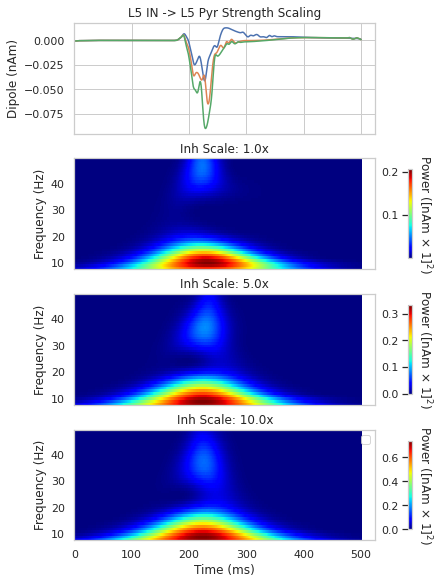

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True)
freqs = np.arange(8, 50)
times = dpl_L5IN_list[0].times
for plot_idx, (plt_dpl, scale) in enumerate(zip(dpl_L5IN_list, inh_scale)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[0].plot(times, dpl_smooth, label=f'{scale}x')
    axes[plot_idx].set_xlabel('')
    plt_dpl.copy().plot_tfr_morlet(freqs, ax=axes[plot_idx+1], show=False, colormap='jet')
    axes[plot_idx+1].set_title(f'Inh Scale: {scale}x')

axes[0].set_title('L5 IN -> L5 Pyr Strength Scaling')
axes[3].set_xlabel('Time (ms)')
axes[0].set_ylabel('Dipole (nAm)')
plt.legend()
#plt.savefig('u19_page2_figures/calcium_l5inh_l5_pyr_strength_sweep.png')

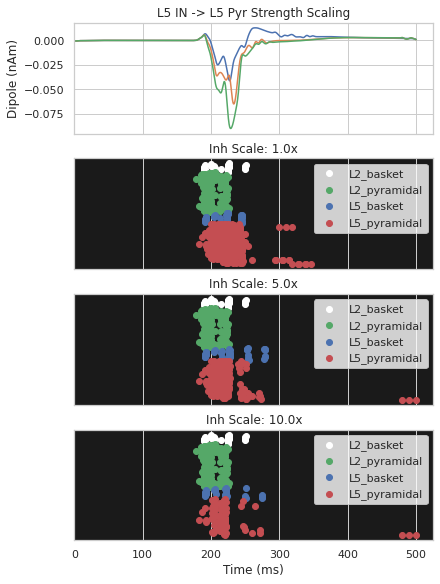

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True)
freqs = np.arange(8, 50)
times = dpl_L5IN_list[0].times
for plot_idx, (plt_dpl, scale, net) in enumerate(zip(dpl_L5IN_list, inh_scale, net_L5IN_list)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[0].plot(times, dpl_smooth, label=f'{scale}x')
    axes[plot_idx+1].set_title(f'Inh Scale: {scale}x')
    net.copy().cell_response.plot_spikes_raster(ax=axes[plot_idx+1], show=False)
    axes[plot_idx].set_xlabel('')


axes[0].set_title('L5 IN -> L5 Pyr Strength Scaling')
axes[3].set_xlabel('Time (ms)')
axes[0].set_ylabel('Dipole (nAm)')
plt.legend()
#plt.savefig('u19_page2_figures/calcium_l5inh_l5_pyr_strength_sweep.png')

In [ ]:
dpl_L2IN_list = list()
net_L2IN_list = list()
conn_list = pick_connection(net_orig, src_gids='L2_basket', target_gids='L5_pyramidal')
inh_scale = [0.1, 1.0, 10.0]
for scale in inh_scale:
    net = net_orig.copy()
    for conn_idx in conn_list:
        net.connectivity[conn_idx]['nc_dict']['A_weight'] *= scale

    with MPIBackend(n_procs=8):
        dpl = simulate_dipole(net, tstop=500, dt=0.05)[0]

    dpl_L2IN_list.append(dpl)
    net_L2IN_list.append(net)

MPI will run over 8 processes
Running 1 trials...
numprocs=8
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 8 cores
Simulat

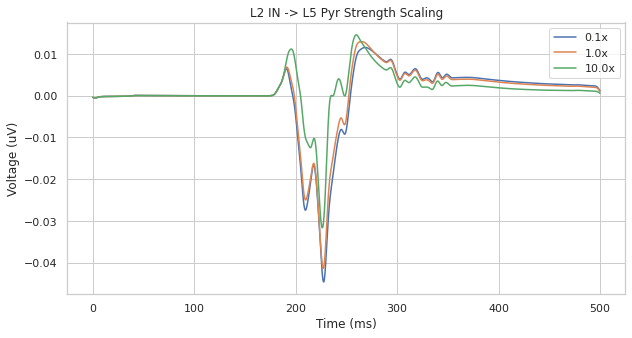

In [ ]:
plt.figure(figsize=(10,5))
times = dpl_L2IN_list[0].times
for plt_dpl, scale in zip(dpl_L2IN_list, inh_scale):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    plt.plot(times, dpl_smooth, label=f'{scale}x')

plt.title('L2 IN -> L5 Pyr Strength Scaling')
plt.xlabel('Time (ms)')
plt.ylabel('Dipole (nAm)')
plt.legend()
plt.savefig('u19_page2_figures/calcium_l2inh_l5_pyr_strength_sweep.png')

NameError: name 'dpl_L2IN_list' is not defined

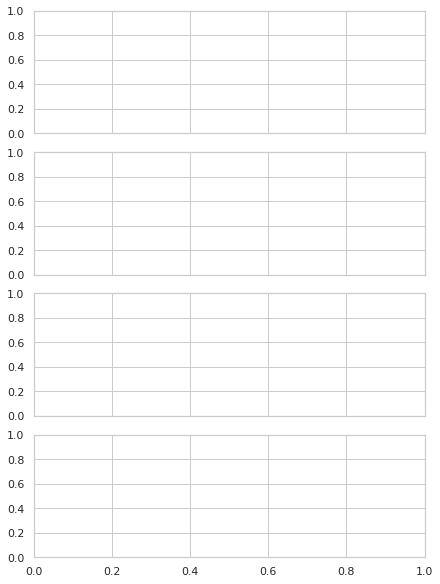

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True)
freqs = np.arange(8, 50)
times = dpl_L2IN_list[0].times
for plot_idx, (plt_dpl, scale) in enumerate(zip(dpl_L2IN_list, inh_scale)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[0].plot(times, dpl_smooth, label=f'{scale}x')
    axes[plot_idx].set_xlabel('')
    plt_dpl.copy().plot_tfr_morlet(freqs, ax=axes[plot_idx+1], show=False, colormap='jet')
    axes[plot_idx+1].set_title(f'Inh Scale: {scale}x')

axes[0].set_title('L2 IN -> L2 Pyr Strength Scaling')
axes[3].set_xlabel('Time (ms)')
axes[0].set_ylabel('Dipole (nAm)')
plt.legend()


In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True)
freqs = np.arange(8, 50)
times = dpl_L2IN_list[0].times
for plot_idx, (plt_dpl, scale, net) in enumerate(zip(dpl_L2IN_list, inh_scale, net_L2IN_list)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[0].plot(times, dpl_smooth, label=f'{scale}x')
    axes[plot_idx+1].set_title(f'Inh Scale: {scale}x')
    net.copy().cell_response.plot_spikes_raster(ax=axes[plot_idx+1], show=False)
    axes[plot_idx].set_xlabel('')


axes[0].set_title('L2 IN -> L2 Pyr Strength Scaling')
axes[3].set_xlabel('Time (ms)')
axes[0].set_ylabel('Dipole (nAm)')
plt.legend()
